In [24]:
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [25]:
# Load the CIFAR-10 dataset
(cifar10_train_images, cifar10_train_labels), (cifar10_test_images, cifar10_test_labels) = tf.keras.datasets.cifar10.load_data()

In [26]:
# Access the first image and its corresponding label from the training dataset
sample_image = cifar10_train_images[0]
sample_label = cifar10_train_labels[0]


In [27]:
sample_image


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

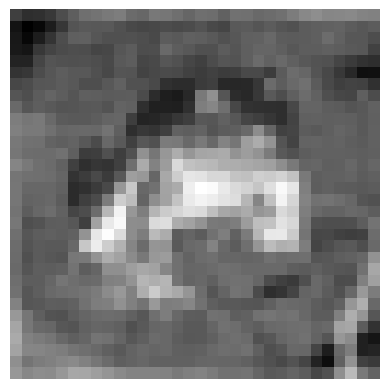

In [34]:
# Access an image from the training dataset (e.g., the first image)
sample_image = cifar10_train_images[0]

# Convert to grayscale
sample_image_gray = sample_image.mean(axis=2)  # Take the mean along the color channels

# Display the grayscale image
plt.imshow(sample_image_gray, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

In [22]:
sample_label

array([6], dtype=uint8)

In [19]:
# Display information about the sample image
print(f"Sample Image Shape: {sample_image.shape}")
print(f"Sample Label: {sample_label}")

Sample Image Shape: (32, 32, 3)
Sample Label: [6]


In [7]:
# Preprocess the dataset
def preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return (images, labels)

In [8]:
# Split the dataset into multiple "client" datasets
num_clients = 10
client_datasets = []
for i in range(num_clients):
    start = i * len(cifar10_train_images) // num_clients
    end = (i + 1) * len(cifar10_train_images) // num_clients
    client_images = cifar10_train_images[start:end]
    client_labels = cifar10_train_labels[start:end]
    client_dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    client_dataset = client_dataset.map(preprocess).batch(20)
    client_datasets.append(client_dataset)

### Differential privacy is a mathematical technique that balances data privacy and data utility. It allows organizations to analyze and share private data without revealing sensitive information about individuals. Here’s how it works:

#### Randomization: Differential privacy introduces controlled randomness (noise) into datasets. The goal is to prevent anyone from identifying specific individuals in the dataset.
#### Privacy Budget (ε): Differential privacy uses a privacy loss parameter, often denoted as ε (epsilon). This parameter controls how much noise is added to the raw dataset. A higher ε value means more accurate but less private data.
##### Example Process:
Suppose you have a dataset with a column containing “Yes” or “No” answers from individuals.
For each individual, you flip a coin:
If it’s heads, you keep the answer as is.
If it’s tails, you flip the coin again:
Heads: Record the answer as “Yes.”
Tails: Record the answer as “No.”
This process adds randomness while maintaining aggregate accuracy.

In [9]:
# Define a simple CNN model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model



def model_fn_standard():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        #It specifies the input specification based on the first client dataset (client_datasets[0].element_spec).
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

def model_fn_with_dp():
    keras_model = create_keras_model()
    optimizer = tfp.DPAdamGaussianOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=0.5,
        num_microbatches=1,
        learning_rate=0.001
    )
    keras_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])



#### In  model_fn_with_dp function, I have used the DPAdamGaussianOptimizer from the tensorflow_privacy library. This optimizer adds Gaussian noise to the gradients during the optimization process, which is a common technique for implementing differential privacy in deep learning models.

In [10]:
def assign_weights_to_keras_model(keras_model, tff_state):
    tff_weights = tff_state.model.trainable
    for var, tff_var in zip(keras_model.trainable_variables, tff_weights):
        var.assign(tff_var)  # Removed .numpy()

In [11]:
def evaluate_model(state, model_fn, test_dataset):
    keras_model = create_keras_model()
    assign_weights_to_keras_model(keras_model, state)

    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    test_images, test_labels = zip(*list(test_dataset))
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)

    loss, accuracy = keras_model.evaluate(test_images, test_labels, verbose=0)
    return loss, accuracy

In [12]:
def check_dataset(dataset):
    for batch in dataset.take(1):
        images, labels = batch
        print(f'Batch shape: {images.shape}, Labels: {labels.numpy()}')

In [13]:
for i, client_dataset in enumerate(client_datasets):
    print(f'Client {i} dataset:')
    check_dataset(client_dataset)

Client 0 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]
 [9]
 [3]
 [2]
 [6]]
Client 1 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [7]
 [9]
 [0]
 [5]
 [2]
 [3]
 [3]
 [3]
 [9]
 [0]
 [9]
 [2]
 [9]
 [1]
 [0]
 [2]
 [3]
 [9]
 [6]]
Client 2 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[1]
 [6]
 [6]
 [8]
 [8]
 [3]
 [4]
 [6]
 [0]
 [6]
 [0]
 [3]
 [6]
 [6]
 [5]
 [4]
 [8]
 [3]
 [2]
 [6]]
Client 3 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[0]
 [6]
 [7]
 [0]
 [4]
 [9]
 [5]
 [8]
 [0]
 [4]
 [3]
 [8]
 [4]
 [7]
 [1]
 [8]
 [3]
 [5]
 [4]
 [5]]
Client 4 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[8]
 [5]
 [0]
 [6]
 [9]
 [2]
 [8]
 [3]
 [6]
 [2]
 [7]
 [4]
 [6]
 [9]
 [0]
 [0]
 [7]
 [3]
 [7]
 [2]]
Client 5 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [9]
 [8]
 [4]
 [0]
 [6]
 [3]
 [1]
 [3]
 [9]
 [9]
 [8]
 [5]
 [8]
 [4]
 [5]
 [0]
 [4]
 [2]
 [3]]
Client 6 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[

In [14]:
# Create federated averaging processes
iterative_process_standard = tff.learning.build_federated_averaging_process(
    model_fn_standard,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

iterative_process_with_dp = tff.learning.build_federated_averaging_process(
    model_fn_standard,  # Use standard model_fn as DP optimizer will be applied in the client update
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [15]:
# Train the standard model
NUM_ROUNDS = 3
state_standard = iterative_process_standard.initialize()
for round_num in range(NUM_ROUNDS):
    state_standard, metrics_standard = iterative_process_standard.next(state_standard, client_datasets)
    print(f'Standard Model - Round {round_num}, metrics={metrics_standard["train"]}')

Standard Model - Round 0, metrics=OrderedDict([('sparse_categorical_accuracy', 0.17964), ('loss', 2.2078638)])
Standard Model - Round 1, metrics=OrderedDict([('sparse_categorical_accuracy', 0.2609), ('loss', 2.0217845)])
Standard Model - Round 2, metrics=OrderedDict([('sparse_categorical_accuracy', 0.30872), ('loss', 1.9185474)])


In [16]:
# Train the differentially private model
state_with_dp = iterative_process_with_dp.initialize()
for round_num in range(NUM_ROUNDS):
    state_with_dp, metrics_with_dp = iterative_process_with_dp.next(state_with_dp, client_datasets)
    print(f'DP Model - Round {round_num}, metrics={metrics_with_dp["train"]}')


DP Model - Round 0, metrics=OrderedDict([('sparse_categorical_accuracy', 0.16242), ('loss', 2.236325)])
DP Model - Round 1, metrics=OrderedDict([('sparse_categorical_accuracy', 0.24062), ('loss', 2.0594568)])
DP Model - Round 2, metrics=OrderedDict([('sparse_categorical_accuracy', 0.29254), ('loss', 1.9599725)])


In [17]:
# Preprocess the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((cifar10_test_images, cifar10_test_labels))
test_dataset = test_dataset.map(preprocess).batch(20)

# Evaluate the standard model
loss_standard, accuracy_standard = evaluate_model(state_standard, model_fn_standard, test_dataset)
print(f'Standard Model - Test loss: {loss_standard}, Test accuracy: {accuracy_standard}')

# Evaluate the differentially private model
loss_with_dp, accuracy_with_dp = evaluate_model(state_with_dp, model_fn_with_dp, test_dataset)
print(f'DP Model - Test loss: {loss_with_dp}, Test accuracy: {accuracy_with_dp}')

Standard Model - Test loss: 1.7991496324539185, Test accuracy: 0.3668000102043152
DP Model - Test loss: 1.8537687063217163, Test accuracy: 0.3522999882698059
